## Data preparation

### Extract features for training

In [ ]:
import pandas as pd

df = pd.read_csv('../varity_project/data/benchmark_dataset.csv')

print(df.columns.tolist())

In [ ]:
df_original = pd.read_csv('../varity_project/data/varity_r_input_data.csv')

print(df_original.columns.tolist())

In [ ]:
import pandas as pd

df_new = pd.read_csv('../varity_project/data/test_set.csv')

#  chr / nt_pos
df_new[["chr","nt_pos"]] = df_new["Location"].str.split(":", expand=True)
df_new["nt_pos"] = df_new["nt_pos"].astype(int)

# Alt allele
df_new.rename(columns={"Allele":"nt_alt"}, inplace=True)

# Ref allele(place holder)
df_new["nt_ref"] = "."

# Amino_acids to aa_ref / aa_alt
df_new[["aa_ref","aa_alt"]] = df_new["Amino_acids"].str.split("/", expand=True)

# Protein position
df_new.rename(columns={"Protein_position":"aa_pos"}, inplace=True)

# p_vid
df_new["p_vid"] = df_new["Uploaded_variation"] 

# Save
df_new.to_csv('../varity_project/data/test_set_prep.csv', index=False)


### Add columns according to user guide

In [ ]:
import pandas as pd

df = pd.read_csv('../varity_project/data/training_set.csv')

# Add new columns
df['extra_data'] = 0
df['set_name']   = 'benchmark'

df.to_csv('../varity_project/data/training_set.csv', index=False)


In [ ]:
import pandas as pd

df = pd.read_csv('../varity_project/data/test_set_prep.csv')

# Add new columns
df['extra_data'] = 0
df['set_name']   = 'benchmark'

df.to_csv('../varity_project/data/test_set_prep.csv', index=False)


## SHAP analysis

In [1]:
import shap
import xgboost as xgb
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import pandas as pd

/home/ning/miniconda3/envs/varity_env/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
/home/ning/miniconda3/envs/varity_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Path
model_path = '../varity_project/output/model/benchmark_dataset_final_MYVARITY_R.model'
data_path = '../varity_project/data/test_set_prep.csv'

# Load the model
model = XGBClassifier()
model.load_model(model_path)

# Load data
df = pd.read_csv(data_path)

# Features used for training
feature_cols = [
    'AllofUs_ALL_AF', 'AlphaMissense_score', 'BayesDel_addAF_score', 'BayesDel_noAF_score', 'CADD_raw', 
    'ClinPred_score', 'DANN_score', 'DEOGEN2_score', 'ESM1b_score', 'Eigen-PC-raw_coding', 'Eigen-raw_coding', 
    'GERP++_RS', 'GERP_91_mammals', 'M-CAP_score', 'MPC_score', 'MVP_score', 'MetaLR_score', 'MetaRNN_score', 
    'MetaSVM_score', 'MutFormer_score', 'MutScore_score', 'MutationAssessor_score', 'MutationTaster_score', 
    'PROVEAN_score', 'Polyphen2_HDIV_score', 'Polyphen2_HVAR_score', 'PrimateAI_score', 'REVEL_score', 
    'RegeneronME_ALL_AF', 'SIFT4G_score', 'SIFT_score', 'VEST4_score', 'bStatistic', 'dbNSFP_POPMAX_AF', 
    'fathmm-XF_coding_score', 'gMVP_score', 'gnomAD4.1_joint_AF', 'phastCons100way_vertebrate', 'phastCons17way_primate', 
    'phastCons470way_mammalian', 'phyloP100way_vertebrate', 'phyloP17way_primate', 'phyloP470way_mammalian'
]

X = df[feature_cols]


In [3]:
# SHAP value
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [5]:
# Visualization
## Beeswarm
shap.summary_plot(
    shap_values, 
    X, 
    feature_names=feature_cols,
    max_display=43,
    show=False
)
plt.savefig("../varity_project/output/img/varity_shap_beeswarm.png", dpi=300, bbox_inches='tight')
plt.close()
print("SHAP beeswarm plot saved")

## Bar chart
mean_shap = np.abs(shap_values).mean(axis=0)
sorted_idx = np.argsort(mean_shap)
sorted_shap_values = mean_shap[sorted_idx]
sorted_feature_names = np.array(feature_cols)[sorted_idx]

# Define correlated groups
feature_groups = {
    "Group_1": [
        "AlphaMissense_score", "BayesDel_addAF_score", "BayesDel_noAF_score", "CADD_raw", "ClinPred_score",
        "Eigen-PC-raw_coding", "Eigen-raw_coding", "GERP++_RS", "MetaLR_score", "MetaRNN_score",
        "MetaSVM_score", "MutScore_score", "MutationTaster_score", "Polyphen2_HDIV_score",
        "Polyphen2_HVAR_score", "PrimateAI_score", "REVEL_score", "VEST4_score",
        "fathmm-XF_coding_score", "gMVP_score", "phastCons100way_vertebrate",
        "phyloP100way_vertebrate", "phyloP470way_mammalian"
    ],
    "Group_2": ["RegeneronME_ALL_AF", "gnomAD4.1_joint_AF"],
    "Group_3": ["SIFT4G_score", "SIFT_score"]
}

# Define group colors
group_colors = {
    "Group_1": "tomato",
    "Group_2": "mediumseagreen",
    "Group_3": "royalblue",
    "Other": "lightgrey"
}

# Map features to colors
feature_to_color = {}
for group, features in feature_groups.items():
    for feat in features:
        feature_to_color[feat] = group_colors[group]

bar_colors = [feature_to_color.get(f, group_colors["Other"]) for f in sorted_feature_names]

plt.figure(figsize=(8, 18))
plt.barh(sorted_feature_names, sorted_shap_values, color=bar_colors)
plt.xlabel('Mean(|SHAP value|)', fontsize=12)
plt.title('Global Feature Importance (SHAP)', fontsize=14)
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('../varity_project/output/img/varity_shap_barplot.png', dpi=300, bbox_inches='tight')
plt.close()
print("SHAP bar chart saved")

SHAP beeswarm plot saved
SHAP bar chart saved


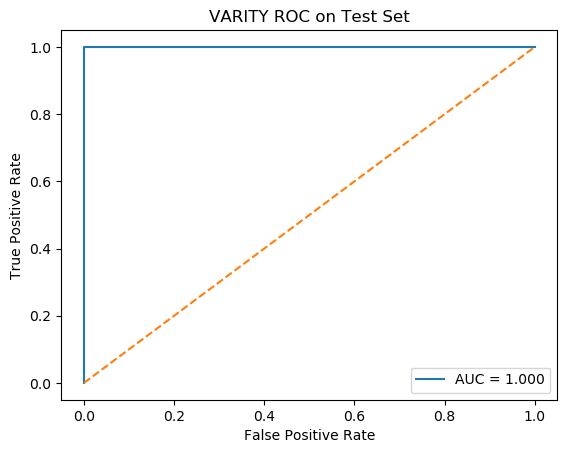

In [6]:

from sklearn.metrics import roc_curve, auc

df = pd.read_csv("../varity_project/output/csv/benchmark_varity_test_test_set_prep_MYVARITY_R.csv")
y_true = df["label"]
y_score = df["MYVARITY_R"]

fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("VARITY ROC on Test Set")
plt.legend()
plt.show()


/home/ning/miniconda3/envs/varity_env/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


Accuracy:  1.000
Precision: 1.000
Recall:    1.000
F1-score:  1.000


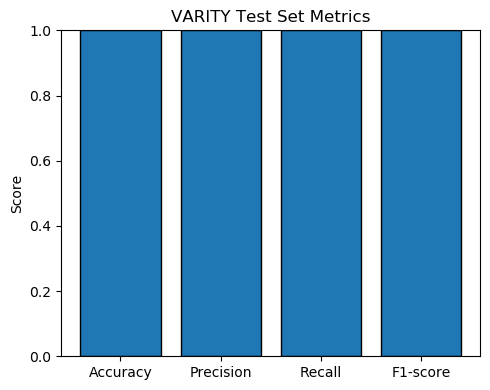

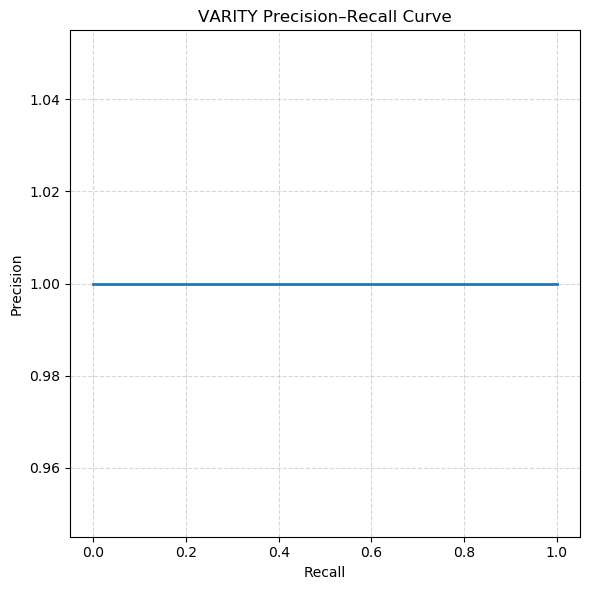

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             precision_recall_curve, confusion_matrix)


# Load data
df = pd.read_csv("../varity_project/output/csv/benchmark_varity_test_test_set_prep_MYVARITY_R.csv")
y_true  = df["label"]
y_score = df["MYVARITY_R"]

# Distribute prediction
y_pred_label = (y_score >= 0.5).astype(int)

acc  = accuracy_score(y_true, y_pred_label)
prec = precision_score(y_true, y_pred_label)
rec  = recall_score(y_true, y_pred_label)
f1   = f1_score(y_true, y_pred_label)

print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")

# Bar chart
plt.figure(figsize=(5,4))
metrics = [acc, prec, rec, f1]
names   = ["Accuracy", "Precision", "Recall", "F1-score"]
plt.bar(names, metrics, edgecolor='k', linewidth=1)
plt.ylim(0,1)
plt.title("VARITY Test Set Metrics")
plt.ylabel("Score")
plt.tight_layout()
plt.savefig("../varity_project/output/img/varity_metrics_bar.png", dpi=300)
plt.show()

# Precision–Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_score)
plt.figure(figsize=(6,6))
plt.plot(recall_vals, precision_vals, lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("VARITY Precision–Recall Curve")
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("../varity_project/output/img/varity_pr_curve.png", dpi=300)
plt.show()



In [2]:
import shap
import xgboost as xgb
from xgboost import XGBClassifier
import numpy as np
import pandas as pd

# Paths
model_path = '../varity_project/output/model/benchmark_dataset_final_MYVARITY_R.model'
data_path = '../varity_project/data/test_set_prep.csv'

# Load model
model = XGBClassifier()
model.load_model(model_path)

# Load data
df = pd.read_csv(data_path)

# Features used for training (exact same names & order)
feature_cols = [
    'AllofUs_ALL_AF','AlphaMissense_score','BayesDel_addAF_score','BayesDel_noAF_score','CADD_raw',
    'ClinPred_score','DANN_score','DEOGEN2_score','ESM1b_score','Eigen-PC-raw_coding','Eigen-raw_coding',
    'GERP++_RS','GERP_91_mammals','M-CAP_score','MPC_score','MVP_score','MetaLR_score','MetaRNN_score',
    'MetaSVM_score','MutFormer_score','MutScore_score','MutationAssessor_score','MutationTaster_score',
    'PROVEAN_score','Polyphen2_HDIV_score','Polyphen2_HVAR_score','PrimateAI_score','REVEL_score',
    'RegeneronME_ALL_AF','SIFT4G_score','SIFT_score','VEST4_score','bStatistic','dbNSFP_POPMAX_AF',
    'fathmm-XF_coding_score','gMVP_score','gnomAD4.1_joint_AF','phastCons100way_vertebrate','phastCons17way_primate',
    'phastCons470way_mammalian','phyloP100way_vertebrate','phyloP17way_primate','phyloP470way_mammalian'
]

# Sanity checks
missing = [c for c in feature_cols if c not in df.columns]
assert len(missing) == 0, f"Missing columns in data: {missing}"

X = df[feature_cols].copy()
# If any non-numeric slips in, convert; and handle NaNs if present
for c in feature_cols:
    if not np.issubdtype(X[c].dtype, np.number):
        X[c] = pd.to_numeric(X[c], errors='coerce')
if X.isna().any().any():
    # simple fill
    X = X.fillna(X.median(numeric_only=True))

# Compute SHAP values
explainer = shap.TreeExplainer(model)
# check_additivity=False to avoid warnings and speed up a bit
shap_values = explainer.shap_values(X, check_additivity=False)

# Global importance = mean absolute SHAP per feature
shap_mean = pd.Series(np.abs(shap_values).mean(axis=0), index=feature_cols)
shap_mean_sorted = shap_mean.sort_values(ascending=False)

# Export Top-10, Top-5, full list
top10 = shap_mean_sorted.head(10).reset_index()
top10.columns = ['feature', 'mean_abs_shap']
top10.to_csv('../varity_project/output/csv/shap_top10_varity.csv', index=False)

top5 = shap_mean_sorted.head(5).reset_index()
top5.columns = ['feature', 'mean_abs_shap']
top5.to_csv('../varity_project/output/csv/shap_top5_varity.csv', index=False)

full_importance = shap_mean_sorted.reset_index()
full_importance.columns = ['feature', 'mean_abs_shap']
full_importance.to_csv('../varity_project/output/csv/shap_importance_full_varity.csv', index=False)

print("Top-10 features by mean(|SHAP|):")
display(top10)


Top-10 features by mean(|SHAP|):


,feature,mean_abs_shap
0,phyloP100way_vertebrate,1.699291
1,MutationTaster_score,1.358072
2,ClinPred_score,0.851645
3,dbNSFP_POPMAX_AF,0.320219
4,GERP++_RS,0.302129
5,M-CAP_score,0.227285
6,gMVP_score,0.214242
7,AllofUs_ALL_AF,0.185422
8,MutScore_score,0.170841
9,phyloP470way_mammalian,0.148968
